In [2]:
!pip install prophet

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import plotly.express as px
from prophet import Prophet
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
plt.style.use('seaborn')

Za početak, učitajmo podatke koje ćemo koristiti u ovoj analizi. To su datoteke athlete_events.csv i noc_regions.csv.

In [5]:
dfRegija = pd.read_csv('noc_regions.csv')
dfRegija.head()

NOC       region                 notes
0  AFG  Afghanistan                   NaN
1  AHO      Curacao  Netherlands Antilles
2  ALB      Albania                   NaN
3  ALG      Algeria                   NaN
4  AND      Andorra                   NaN

In [6]:
dfSport = pd.read_csv('athlete_events.csv')
dfSport.head()

ID                      Name  ...                             Event  Medal
0   1                 A Dijiang  ...       Basketball Men's Basketball    NaN
1   2                  A Lamusi  ...      Judo Men's Extra-Lightweight    NaN
2   3       Gunnar Nielsen Aaby  ...           Football Men's Football    NaN
3   4      Edgar Lindenau Aabye  ...       Tug-Of-War Men's Tug-Of-War   Gold
4   5  Christine Jacoba Aaftink  ...  Speed Skating Women's 500 metres    NaN

[5 rows x 15 columns]

In [7]:
dfRegija.shape

(230, 3)

Datoteka u kojoj se nalaze države koje su sudjelovale na Olimpijskim igrama(dalje u seminaru OI) se sastoji od 230 redaka i 3 stupca. Budući organizacija Ujedinjenih naroda trenutno broji 193 članice te s obzirom da su prve OI održane 1896. godine u Grčkoj i uzimajući u obzir povijesne okolnosti nastajanja i prestajanja postojanja država od tada do danas, smatramo da je ova datoteka vjerojatno dobro pokrila zastupljenost država na OI. Također, u ovoj se datoteci nalaze i države koje više ne postoje, ali su u jednom povijesnom razdoblju bile sastavni dio OI.

In [8]:
dfSport.shape

(271116, 15)

Popriličan broj sportaša je dobio priliku pokazati svoje vještine na OI, iako smo smatrali da je taj broj bio i veći.

In [9]:
dfUkupno = dfSport.merge(dfRegija, how='left', on='NOC')
dfUkupno.head()

ID                      Name Sex  ...  Medal       region  notes
0   1                 A Dijiang   M  ...    NaN        China    NaN
1   2                  A Lamusi   M  ...    NaN        China    NaN
2   3       Gunnar Nielsen Aaby   M  ...    NaN      Denmark    NaN
3   4      Edgar Lindenau Aabye   M  ...   Gold      Denmark    NaN
4   5  Christine Jacoba Aaftink   F  ...    NaN  Netherlands    NaN

[5 rows x 17 columns]

In [10]:
dfUkupno = dfUkupno.rename(columns={'region':'Region', 'notes':'Notes'})
dfUkupno.head()

ID                      Name Sex  ...  Medal       Region  Notes
0   1                 A Dijiang   M  ...    NaN        China    NaN
1   2                  A Lamusi   M  ...    NaN        China    NaN
2   3       Gunnar Nielsen Aaby   M  ...    NaN      Denmark    NaN
3   4      Edgar Lindenau Aabye   M  ...   Gold      Denmark    NaN
4   5  Christine Jacoba Aaftink   F  ...    NaN  Netherlands    NaN

[5 rows x 17 columns]

In [11]:
dfUkupno.shape

(271116, 17)

In [12]:
dfUkupno.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 271116 entries, 0 to 271115
Data columns (total 17 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      271116 non-null  int64  
 1   Name    271116 non-null  object 
 2   Sex     271116 non-null  object 
 3   Age     261642 non-null  float64
 4   Height  210945 non-null  float64
 5   Weight  208241 non-null  float64
 6   Team    271116 non-null  object 
 7   NOC     271116 non-null  object 
 8   Games   271116 non-null  object 
 9   Year    271116 non-null  int64  
 10  Season  271116 non-null  object 
 11  City    271116 non-null  object 
 12  Sport   271116 non-null  object 
 13  Event   271116 non-null  object 
 14  Medal   39783 non-null   object 
 15  Region  270746 non-null  object 
 16  Notes   5039 non-null    object 
dtypes: float64(3), int64(2), object(12)
memory usage: 37.2+ MB


In [13]:
print("Podaci koji nedostaju:  {}".format(dfSport.isnull().any().any()))
dfUkupno.isnull().sum()

Podaci koji nedostaju:  True


ID             0
Name           0
Sex            0
Age         9474
Height     60171
Weight     62875
Team           0
NOC            0
Games          0
Year           0
Season         0
City           0
Sport          0
Event          0
Medal     231333
Region       370
Notes     266077
dtype: int64

Vidimo da podaci nedostaju u stupcima Age, Height, Weight, Medal, Region and Notes. Kako nam Notes nije važan u proučavanju podataka za naš seminar, mi ćemo izbrisati taj stupac iz dfUkupno.

In [14]:
dfUkupno.drop(["Notes"],axis=1,inplace=True)


In [15]:
dfUkupno.head(4)

ID                  Name Sex  ...                         Event  Medal   Region
0   1             A Dijiang   M  ...   Basketball Men's Basketball    NaN    China
1   2              A Lamusi   M  ...  Judo Men's Extra-Lightweight    NaN    China
2   3   Gunnar Nielsen Aaby   M  ...       Football Men's Football    NaN  Denmark
3   4  Edgar Lindenau Aabye   M  ...   Tug-Of-War Men's Tug-Of-War   Gold  Denmark

[4 rows x 16 columns]

Sada ćemo nadopuniti vrijednosti za Age, Weight, Height, Region i Medal.

In [16]:
dfUkupno['Age'].fillna(value=dfUkupno['Age'].mean(),inplace=True)
dfUkupno['Height'].fillna(value=dfUkupno['Height'].mean(),inplace=True)
dfUkupno['Weight'].fillna(value=dfUkupno['Weight'].mean(),inplace=True)
dfUkupno['Region'].fillna(value="Nije navedeno",inplace=True)
dfUkupno['Medal'].fillna(value="Nije osvojena",inplace=True)

In [17]:
print("Podaci koji nedostaju:  {}".format(dfSport.isnull().any().any()))
dfUkupno.isnull().sum()

Podaci koji nedostaju:  True


ID        0
Name      0
Sex       0
Age       0
Height    0
Weight    0
Team      0
NOC       0
Games     0
Year      0
Season    0
City      0
Sport     0
Event     0
Medal     0
Region    0
dtype: int64

Null vrijednosti za Age, Weight i Height smo zamijenili prosjekom tih stupaca jer smatramo da će takva zamjena najmanje utjecati na daljnu obradu podataka. Null vrijednosti za Region smo zamijenili s Nije navedeno, a Null vrijednosti za medalju smo zamijenili s Nije osvojeno jer to predstavlja sve sportaše koji su sudjelovali na OI, ali nisu uspjeli osvojiti jedno od 3 odličja.

In [18]:
najzastupljenijeZemlje = dfUkupno.Team.value_counts().sort_values(ascending=False).head(20)
najzastupljenijeZemlje

United States    17847
France           11988
Great Britain    11404
Italy            10260
Germany           9326
Canada            9279
Japan             8289
Sweden            8052
Australia         7513
Hungary           6547
Poland            6143
Switzerland       5844
Netherlands       5718
Soviet Union      5535
Finland           5379
Spain             5224
China             4975
Russia            4922
Austria           4866
Norway            4708
Name: Team, dtype: int64

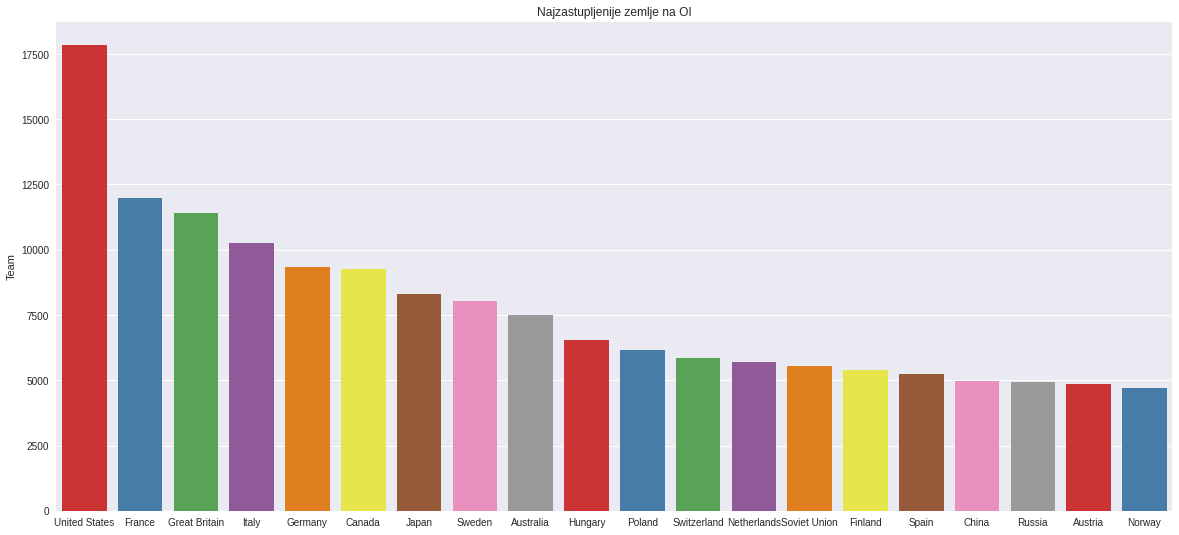

In [19]:
plt.figure(figsize=(20,9))
plt.title('Najzastupljenije zemlje na OI')
sns.barplot(x=najzastupljenijeZemlje.index, y= najzastupljenijeZemlje, palette='Set1')

Ovaj graf nam prikazuje 20 najzastupljenijih zemalja na OI. Vidimo da je SAD dosada daleko najviše sportaša poslao na OI. 

In [20]:
boje=[ "#14cc60","#036d19","#09a129"]
fig = px.box(dfUkupno, x="Year", y="Age",title="<b>Kretanje godina sportaša na OI</b>",color_discrete_sequence=boje,template = "none")
fig.update_layout(plot_bgcolor = " whitesmoke"
                 )
fig.show()

Ovaj graf nam prikazuje kretanje godina sudionika na svakim OI. Prosjek godina natjecatelja je između 20 i 30 što se poklapa s prosječnim zenitom forme sportaša. Vidimo da je najstariji sudionik na OI bio 97-godišnjak koji je nastupio na OI 1928 u Amsterdamu. Ovo je prilično iznenađujući podatak za nas. Pogledajmo o kojem se natjecatelju radi.

In [21]:
najstarijiSudionik = dfUkupno[(dfUkupno.Age == 97)]
najstarijiSudionik

ID                    Name  ...          Medal  Region
257054  128719  John Quincy Adams Ward  ...  Nije osvojena     USA

[1 rows x 16 columns]

Radi se o J.Q.A.Wardu iz SAD-a koji se natjecao u umjetničkoj disciplini. To nas je dovelo do još jednog iznenađenja jer nismo znali da su na OI bile zastupljene umjetničke discipline. Nažalost, nije osvojio medalju, ali samim dolaskom u toj dobi na OI je zaslužio naklon.

Također, iz gornjeg grafa vidimo da je najmlađi natjecalj imao 10 godina. On je se natjecao 1896. u Ateni. Pogledajmo o kojem se natjecatelju radi.

In [22]:
najmladiSudionik = dfUkupno[(dfUkupno.Age == 10)]
najmladiSudionik

ID                Name  ...   Medal  Region
142882  71691  Dimitrios Loundras  ...  Bronze  Greece

[1 rows x 16 columns]

Najmlađi natjecatelj u povijesti i još uz to osvojio brončanu medalju iz gimnastike. Uspjeh vrijedan divljenja.

Pogledajmo sada distribuciju godina natjecalja od 1896. do 2016.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



Text(0.5, 1.0, 'Age Distribution of Athletes')

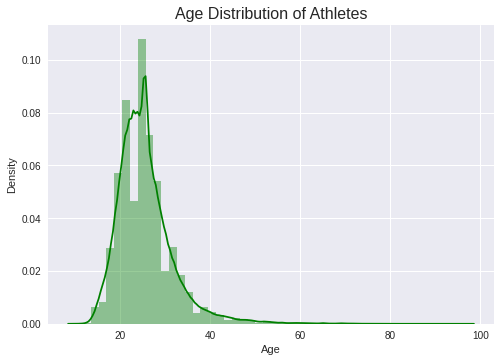

In [23]:
distribucijaGodina=sns.distplot(dfUkupno['Age'].dropna(),color='Green')
distribucijaGodina.set_title('Age Distribution of Athletes',fontsize=16,fontweight=200)

In [24]:
dfUkupno.rename(columns={"Broj sudionika":"ID"},inplace=True)
dfUkupno.head(2)

ID       Name Sex  ...                         Event          Medal  Region
0   1  A Dijiang   M  ...   Basketball Men's Basketball  Nije osvojena   China
1   2   A Lamusi   M  ...  Judo Men's Extra-Lightweight  Nije osvojena   China

[2 rows x 16 columns]

In [25]:
brojSudionika= dfUkupno.groupby('Year').count()['ID'].reset_index()
line_colors=[ "#14cc60","#036d19","#09a129"]
fig= px.line(brojSudionika,x='Year',y='ID',title="<b>Kretanje broja sudionika na OI</b>",markers=True,color_discrete_sequence=line_colors,template = "none")
fig.update_layout(plot_bgcolor = " whitesmoke")
fig.show()

In [26]:
line_colors=["#09a129", "#036d19"]
fig=px.histogram(brojSudionika,x='Year',y='ID',title="<b>Broj sudionika</b>",nbins=70,color_discrete_sequence=line_colors,template = "none")
fig.update_layout(plot_bgcolor = " whitesmoke")
fig.show()

Iz grafa možemo vidjeti kako se broj sudionika na OI s godinama povećavao. Najveći broj sudionika je bio 1992.godine u Barceloni. Također, iz grafa se lako vidi kako je broj sudionika na Zimskim OI znatno manji nego na Ljetnim OI. 

Pogledajmo sada zastupljenost žena na OI.

In [27]:
zeneOI= dfUkupno[dfUkupno["Sex"]=="F"]
zeneOI.head(5)

ID                      Name  ...          Medal       Region
4   5  Christine Jacoba Aaftink  ...  Nije osvojena  Netherlands
5   5  Christine Jacoba Aaftink  ...  Nije osvojena  Netherlands
6   5  Christine Jacoba Aaftink  ...  Nije osvojena  Netherlands
7   5  Christine Jacoba Aaftink  ...  Nije osvojena  Netherlands
8   5  Christine Jacoba Aaftink  ...  Nije osvojena  Netherlands

[5 rows x 16 columns]

Text(0.5, 1.0, '<b>Žene na OI</b>')

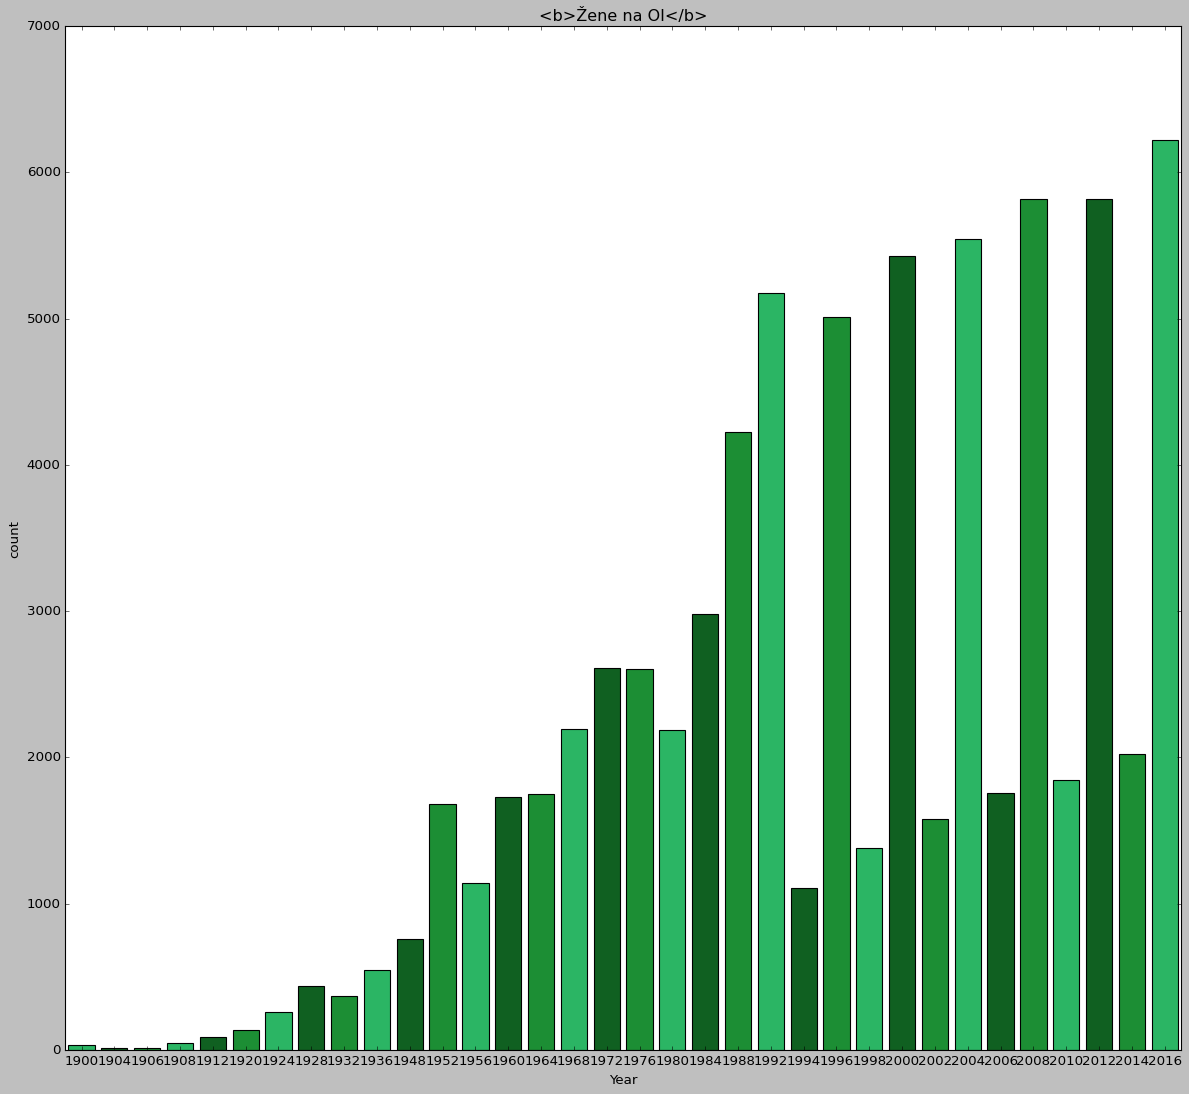

In [28]:
plt.style.use(['classic'])
plt.figure(figsize=(18,16))
theme=[ "#14cc60","#036d19","#09a129"]
sns.countplot(x='Year', data=zeneOI, palette=theme)
plt.title('<b>Žene na OI</b>')

Vidimo da žene nisu nastupale na prvim modernim OI 1896 godine. S godinama se broj žena na OI rapidno povećavao. Vidimo da je najveći broj ženskih sudionika bio 2016.godine u Rio de Janeiru. Odnos ženskih sudionika na Zimskim i Ljetnim OI se poklapa s ukupnim podacima(gledajuci od 1994. kad se održavanje OI počelo razdvajati na svako dvije godine).

In [29]:
fig = px.histogram(dfUkupno, x="Season", color="Sex", barmode = "group", 
             color_discrete_map= {'M': 'Orange', 'F': 'Blue'},
            )
fig.update_layout(
            title = "Odnos sudjelovanja muških i ženskih sportaša na zimskim i ljetnim OI",
            yaxis_title = "Broj sportaša")

Na grafu vidimo odnos broja muških i ženskih sportaša na zimskim i ljetnim OI.

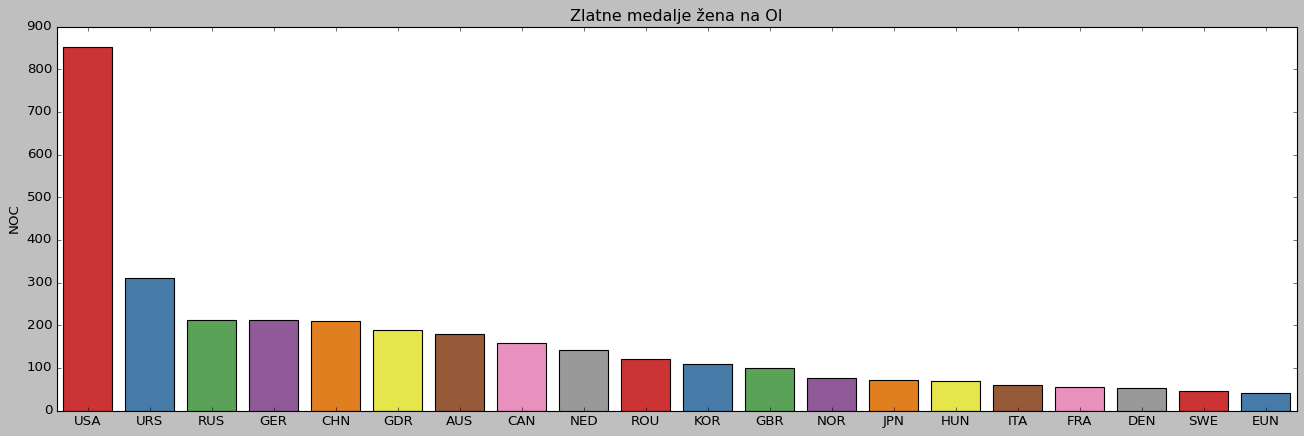

In [30]:
zlatne_medalje_zene = zeneOI[(zeneOI.Medal == 'Gold')]
zlatoZemljeZene=zlatne_medalje_zene.NOC.value_counts().sort_values(ascending = False).head(20)
plt.figure(figsize=(20,6))
plt.title('Zlatne medalje žena na OI')
sns.barplot(x=zlatoZemljeZene.index, y= zlatoZemljeZene, palette='Set1')

Ovaj graf nam prikazuje iz kojih zemalja stižu najuspješnije ženske olimpijke. Natjecateljice iz SAD-a su daleko najuspješnije. Odnos među ostalim zemljama je ravnopravniji. Stoga možemo zaključiti da SAD daleko najviše od svih zemalja ulaže u ženski sport.

In [31]:
muskivszenske=dfUkupno.groupby(['Sex','Year']).count().reset_index()
line_colors = ["#0a2e36",'#27fb6b']
a=px.line(muskivszenske,x="Year",y="ID",color='Sex',markers=True,color_discrete_sequence=line_colors,template = "none")
a.update_layout(plot_bgcolor = "whitesmoke",
    title="<b>Odnos muških i ženskih sudionika na OI</b>",
    yaxis_title="Broj sudionika"
)
a.show()

Na ovom grafu vidimo odnos muških i ženskih sudionika na OI. Vidimo da je i dalje muških sudionika na OI više u odnosu na ženske sudionice, ali je taj broj u odnosu na početna izdanja OI znatno smanjen. Također, vidimo kako se odnos muških i ženskih sudionika na Zimskim i Ljetnim OI podudara(razmjerno ih je manje na Zimskim u odnosu na Ljetne).

**Provjerimo sada uspješnost zemalja po osvojenim medaljama.**

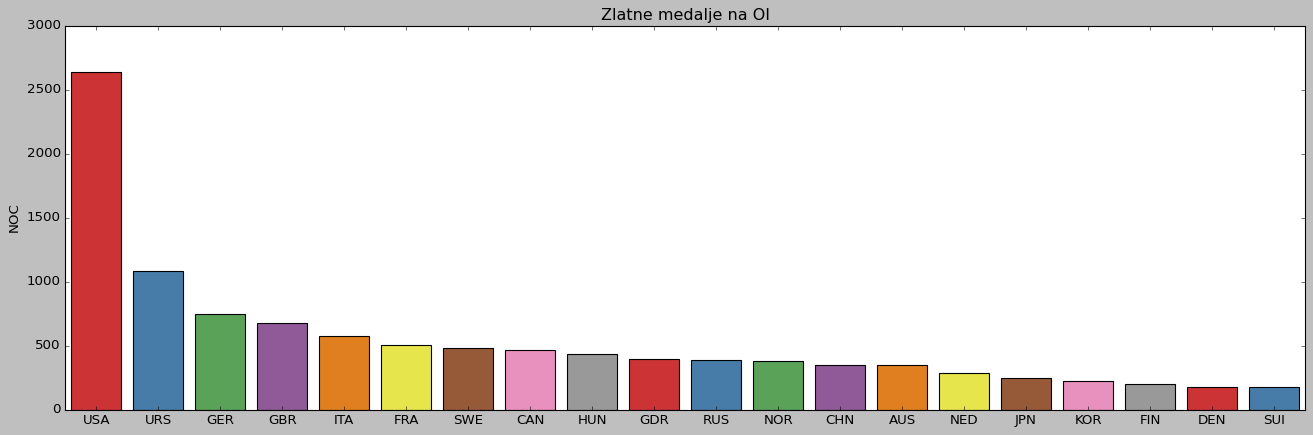

In [32]:
zlatne_medalje = dfUkupno[(dfUkupno.Medal == 'Gold')]
zlatoZemlje=zlatne_medalje.NOC.value_counts().sort_values(ascending = False).head(20)
plt.figure(figsize=(20,6))
plt.title('Zlatne medalje na OI')
sns.barplot(x=zlatoZemlje.index, y= zlatoZemlje, palette='Set1')


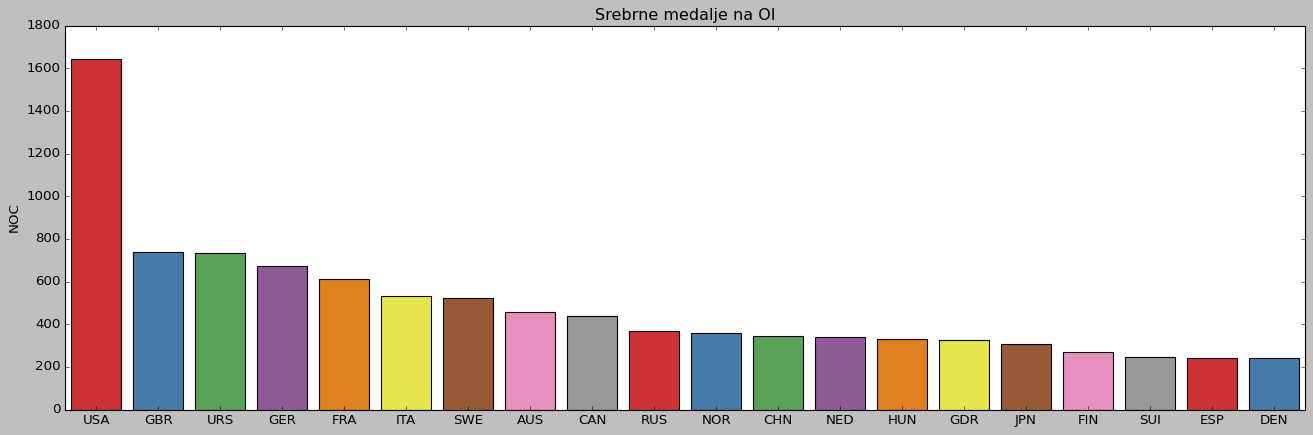

In [33]:
srebrne_medalje = dfUkupno[(dfUkupno.Medal == 'Silver')]
srebroZemlje=srebrne_medalje.NOC.value_counts().sort_values(ascending = False).head(20)
plt.figure(figsize=(20,6))
plt.title('Srebrne medalje na OI')
sns.barplot(x=srebroZemlje.index, y= srebroZemlje, palette='Set1')


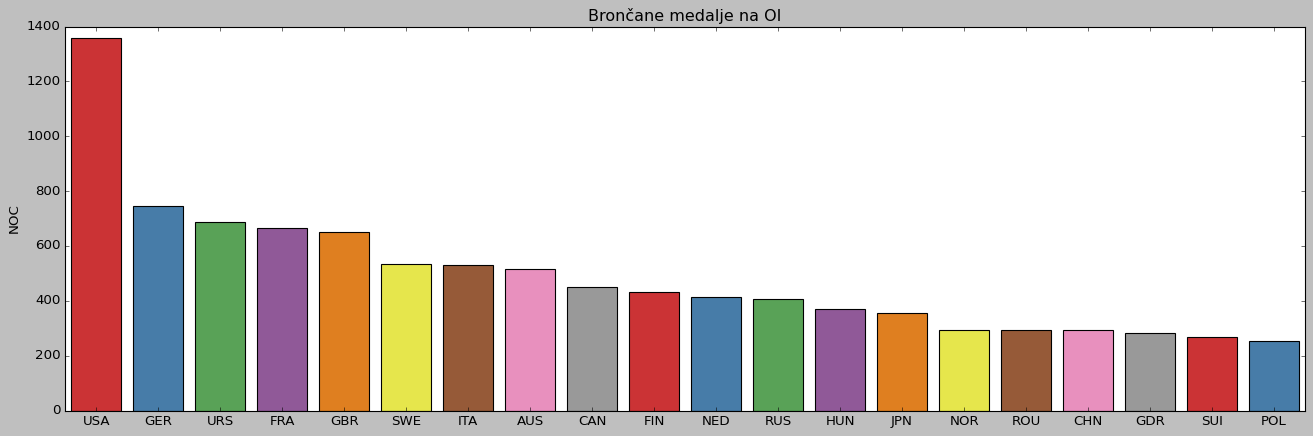

In [34]:
broncane_medalje = dfUkupno[(dfUkupno.Medal == 'Bronze')]
broncaZemlje=broncane_medalje.NOC.value_counts().sort_values(ascending = False).head(20)
plt.figure(figsize=(20,6))
plt.title('Brončane medalje na OI')
sns.barplot(x=broncaZemlje.index, y= broncaZemlje, palette='Set1')


Nakon što smo provjerili odnos po zemljama za sva 3 odličja, pogledajmo sada kakav je odnos država i ukupno osvojenih medalja.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



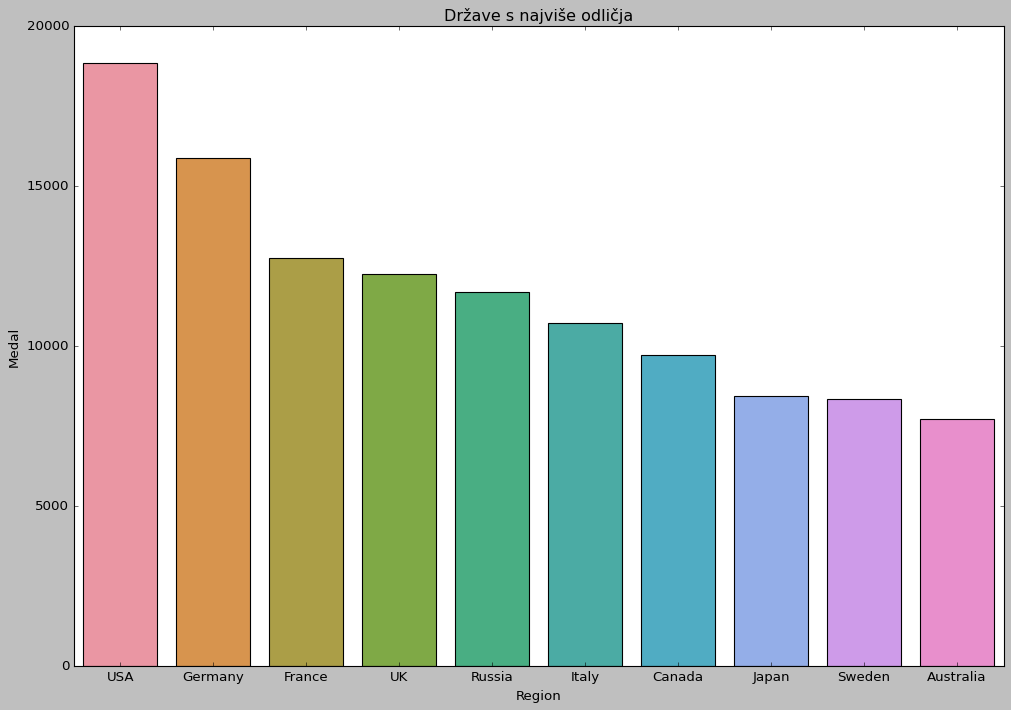

In [35]:
plt.figure(figsize=(15, 10))
topDrzave=dfUkupno.groupby('Region')['Medal'].count().nlargest(10).reset_index()
sns.barplot('Region','Medal',data=topDrzave)
plt.title('Države s najviše odličja')
plt.show()

Vidimo da je SAD najuspješnija nacija u povijesti OI. Taj rezultat nam je bio i očekivan obzirom na ulaganja koja ta zemlja i budući su bilivodeći u broju svih odličja.

In [36]:
odnosSpolovaMedalje= dfUkupno[(dfUkupno['Medal']=="Gold")|(dfUkupno['Medal']=="Silver")|(dfUkupno['Medal']=="Bronze")].groupby(['Year',"Sex"]).count().sort_values(by="ID",ascending=False).reset_index()

In [37]:
fig = px.bar(odnosSpolovaMedalje, x="Year", y="Medal", color="Sex", title="<b>Odnos podijeljenih muških i ženskih medalja</b>",
              color_discrete_map={'M': '#036d19', 'F': '#27FB6B'})
fig.update_layout(plot_bgcolor = " whitesmoke"

    )
fig.show()

Vidimo da je broj sportova u kojima se dijele medalje za muškarce i žene u posljednjem periodu ujednačen.

Pogledajmo sada koji je sportaš najuspješniji na OI.

In [38]:
topUspjehSportas= dfUkupno[(dfUkupno['Medal']=="Gold")|(dfUkupno['Medal']=="Silver")|(dfUkupno['Medal']=="Bronze")].groupby(['Name',"Team","Sport"]).count().sort_values(by="ID",ascending=False).reset_index()
topUspjehSportas.head(5)

Name           Team  ... Medal  Region
0             Michael Fred Phelps, II  United States  ...    28      28
1  Larysa Semenivna Latynina (Diriy-)   Soviet Union  ...    18      18
2        Nikolay Yefimovich Andrianov   Soviet Union  ...    15      15
3                 Ole Einar Bjrndalen         Norway  ...    13      13
4                 Edoardo Mangiarotti          Italy  ...    13      13

[5 rows x 16 columns]

Vidimo da je najuspješniji sportaš u povijesti plivač Michael Phelps iz SAD-a. Iz tablice možemo isčitati i da je nauspješnija sportašica u povijesti OI gimnastičarka Larysa Semenivna Latynina koja je nastupala pod zastavom Sovjetskog saveza.

Pogledajmo sada kako je Hrvatska izgledala dosad na OI.

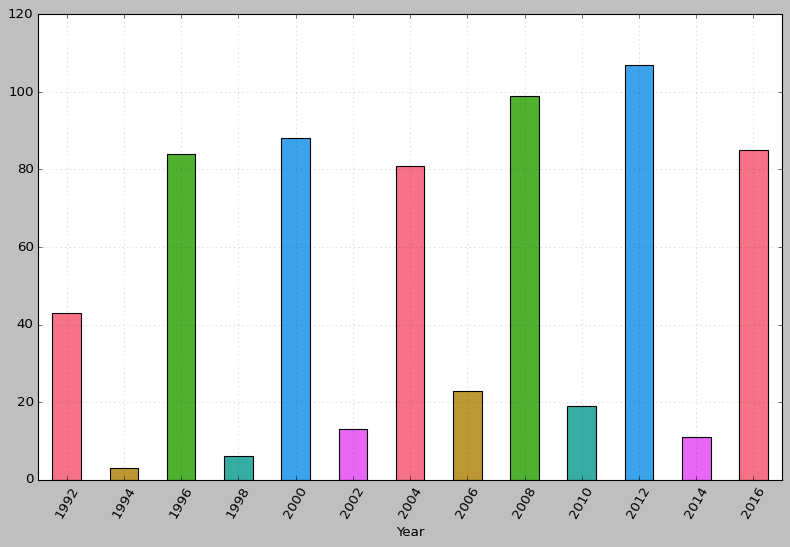

In [39]:
Hrvatska=dfUkupno[dfUkupno.Team=="Croatia"]
hrv=Hrvatska.loc[:,["ID","Year"]]

plt.figure(figsize=(12,16))
plt.subplot(211)

croatia=hrv.groupby("Year")["ID"].nunique().plot(kind = "bar",
                                                 color = sns.color_palette("husl"),
                                                 linewidth = 1)
plt.xticks(rotation = 60)
plt.grid(True,alpha=.3)
plt.show()

Vidimo da je se Hrvatska prvi put na OI pojavila 1992. godine u Barceloni. Najviše smo sportaša imali 2012. godine u Londonu, a najmanje 1994. godine u Lillehameru.

Pogledajmo sada koji su gradovi najviše puta ugostili najbolje sportašice i sportaše.

In [40]:
domacin = dfUkupno.groupby('City').apply(lambda x:x['Year'].unique()).to_frame().reset_index()
domacin.columns=['Grad','Godina']
domacin['Domacinstvo']=[len(c) for c in domacin['Godina']]
domacin.sort_values('Domacinstvo',ascending=False).head(5)


Grad              Godina  Domacinstvo
3         Athina  [2004, 1906, 1896]            3
17        London  [2012, 1948, 1908]            3
30  Sankt Moritz        [1928, 1948]            2
26         Paris        [1900, 1924]            2
37     Stockholm        [1912, 1956]            2

In [42]:
dfZlato= dfUkupno[(dfUkupno.Medal == 'Gold')]
dfZlato.head()

ID                     Name  ... Medal   Region
3    4     Edgar Lindenau Aabye  ...  Gold  Denmark
42  17  Paavo Johannes Aaltonen  ...  Gold  Finland
44  17  Paavo Johannes Aaltonen  ...  Gold  Finland
48  17  Paavo Johannes Aaltonen  ...  Gold  Finland
60  20       Kjetil Andr Aamodt  ...  Gold   Norway

[5 rows x 16 columns]

In [43]:
masterDisciplines = dfZlato['Sport'].value_counts(ascending=False) 

In [44]:
#Najuspješnija disciplina
masterDisciplines.head(1)

Athletics    1339
Name: Sport, dtype: int64

Obratimo sada pažnju i na uspjehe hrvatskih sportaša na OI.

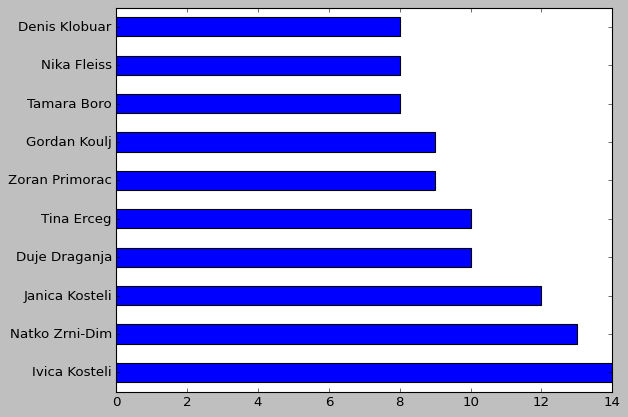

In [49]:
mostCapsSportasHrv = Hrvatska['Name'].value_counts(ascending=False)[:10].plot(kind='barh')

Vidimo da su hrvatski skijaši Ivica Kostelić i Natko Zrnčić-Dim dva muška sportaša s najviše nastupa, dok kod žena predvladava Janica Kostelić te se priključuje tu i Tina Erceg.

In [50]:
mostCapsSportHrv=Hrvatska['Sport'].value_counts(ascending=False) 

In [51]:
mostCapsSportHrv[:10]

Swimming                106
Alpine Skiing            93
Handball                 89
Water Polo               77
Athletics                64
Basketball               58
Shooting                 47
Rowing                   46
Cross Country Skiing     46
Sailing                  44
Name: Sport, dtype: int64

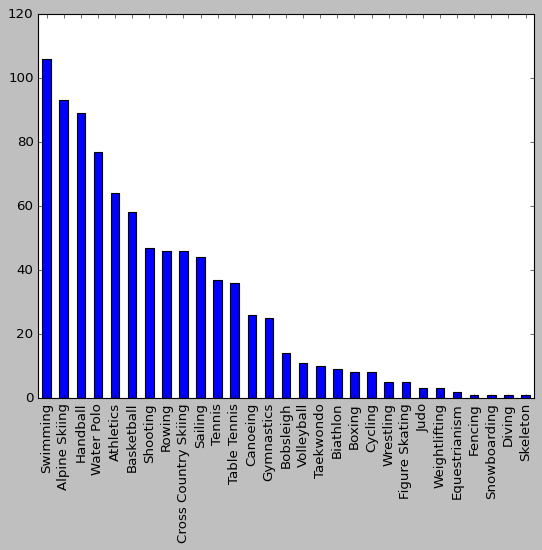

In [52]:
mostCapsSportHrv.plot(kind='bar')

Iz grafa možemo iščitati da su se hrvatski sportaši najčeće natjecali u plavanju, skijanju, rukometu vaterpolu i atletici, te također od ostalih možemo spomenuti košarku, veslanje i tenis.

In [79]:
dfUkupno.Team[dfUkupno.Team=="Croatia"].value_counts().sort_values(ascending=False).head(20)
zlatne_medaljeHRV = dfUkupno[(dfUkupno.Medal == 'Gold')].Team[dfUkupno.Team=="Croatia"].value_counts().sort_values(ascending=False).head(20)

In [80]:
zlatne_medaljeHRV

Croatia    58
Name: Team, dtype: int64

Broj zlatnih medalja za Hrvatsku na OI je 58.

In [81]:
srebro_medaljeHRV = dfUkupno[(dfUkupno.Medal == 'Silver')].Team[dfUkupno.Team=="Croatia"].value_counts().sort_values(ascending=False).head(20)

In [82]:
srebro_medaljeHRV

Croatia    54
Name: Team, dtype: int64

Broj srebrnih medalja za Hrvatsku na OI je 54.

In [83]:
bronca_medaljeHRV = dfUkupno[(dfUkupno.Medal == 'Bronze')].Team[dfUkupno.Team=="Croatia"].value_counts().sort_values(ascending=False).head(20)

In [84]:
bronca_medaljeHRV

Croatia    37
Name: Team, dtype: int64

Broj brončanih medalja za Hrvatsku na OI je 37.

Sada ćemo promotriti osvajače zlatnih medalja za Hrvatsku na OI no smao njih prvih 10.

In [100]:
osvajaciZlataHRV=dfUkupno.Name[(dfUkupno.Team=='Croatia')][dfUkupno.Medal=='Gold'].value_counts()
osvajaciZlataHRV[:10]

Janica Kosteli    4
Venio Losert      2
Valter Matoevi    2
Sandra Perkovi    2
Slavko Golua      2
Zoran Mikuli      1
Petar Muslim      1
Alvaro Nainovi    1
Paulo Obradovi    1
Josip Pavi        1
Name: Name, dtype: int64

Sada ćemo promotriti osvajače srebrnih medalja za Hrvatsku na OI no smao njih prvih 10.

In [101]:
osvajaciSrebraHRV=dfUkupno.Name[(dfUkupno.Team=='Croatia')][dfUkupno.Medal=='Silver'].value_counts()
osvajaciSrebraHRV[:10]

Ivica Kosteli      4
Damir Martin       2
Janica Kosteli     2
Nika Skelin        1
Antonio Petkovi    1
Draen Petrovi      1
Dino Raa           1
David ain          1
Anelo etka         1
Dubravko imenc     1
Name: Name, dtype: int64

Sada ćemo promotriti osvajače brončanih medalja za Hrvatsku na OI no smao njih prvih 10.

In [102]:
osvajaciBronceHRV=dfUkupno.Name[(dfUkupno.Team=='Croatia')][dfUkupno.Medal=='Bronze'].value_counts()
osvajaciBronceHRV[:10]

Goran imun Ivanievi    2
Mirko Alilovi          1
Venio Losert           1
Snjeana Peji           1
Nikolaj Pealov         1
Silvijo Petriko        1
Goran Prpi             1
Sandra ari             1
Nika Skelin            1
Sinia Skelin           1
Name: Name, dtype: int64